#### This code generates large dataframe containing multiple timeseries

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

from sklearn import tree

from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

from graphviz import Source

#### parameters to set

In [11]:
n_series = 6
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-07 23:59:59'

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

# tuning parameters
cut = 0.55
window = 24

#### generate normal data

In [12]:
dti=pd.DatetimeIndex(start=start_date,end=end_date, freq='s')
n_timesteps = len(dti)
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df['link '+str(s)] = pd.Series(v)
df['Flag']=0
df['auc_score']=0.5
df.index = dti
df.head()

,link 0,link 1,link 2,link 3,link 4,link 5,Flag,auc_score
2017-08-01 00:00:00,0.354895,0.217993,0.299847,0.108019,0.015627,0.145609,0,0.5
2017-08-01 00:00:01,0.360336,0.274541,0.287631,0.127637,0.029007,0.159445,0,0.5
2017-08-01 00:00:02,0.344362,0.238907,0.302117,0.100432,0.028205,0.146499,0,0.5
2017-08-01 00:00:03,0.347041,0.249871,0.292465,0.123998,0.027990,0.156493,0,0.5
2017-08-01 00:00:04,0.349467,0.256452,0.293963,0.149047,0.025372,0.135287,0,0.5


#### generate anomalies

In [13]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = int(n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    print('affected:', affects, df.iloc[start].name, df.iloc[end].name)
    for s in affects:
        df.iloc[start:end,s] = df.iloc[start:end,s] + random.random() * 0.2
    df.iloc[start:end,n_series]=1
        

affected: [0, 4, 2, 1] 2017-08-04 19:42:17 2017-08-04 20:39:28
affected: [2, 5, 1] 2017-08-02 08:52:35 2017-08-02 10:57:00
affected: [0, 5, 2, 1, 3] 2017-08-07 00:48:02 2017-08-07 01:09:34
affected: [1, 2, 3] 2017-08-06 14:06:20 2017-08-06 14:32:08
affected: [2, 5, 4, 0] 2017-08-05 03:59:13 2017-08-05 06:47:32
affected: [3] 2017-08-02 06:13:02 2017-08-02 08:36:03


#### enforce range

In [14]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

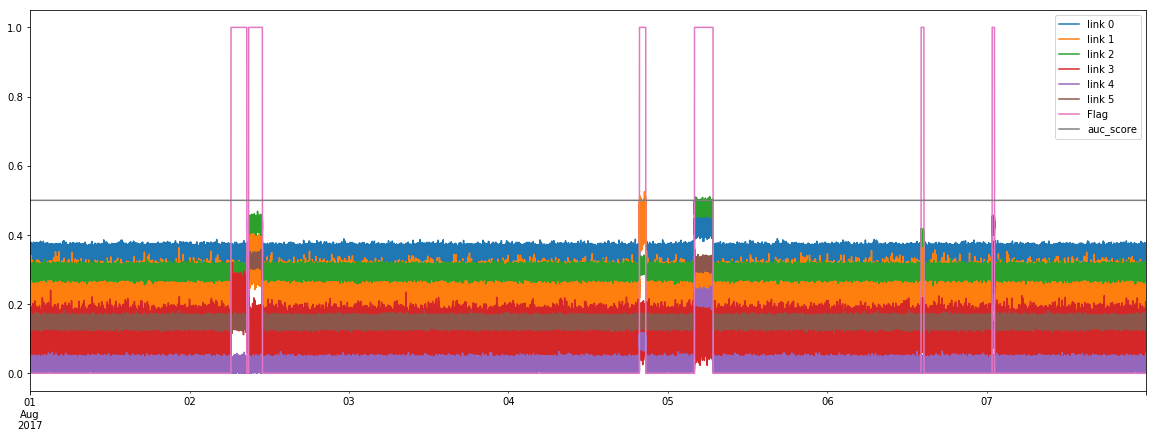

In [15]:
df.plot(figsize=(20,7))

#### functions

In [16]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    del X_ref['Flag']
    del X_ref['auc_score']
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    del X_sub['Flag']
    del X_sub['auc_score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
#     dtc=DecisionTreeClassifier()
    clf = AdaBoostClassifier() #dtc
#     clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ("auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > cut: 
        plot_roc(fpr, tpr, auc_score)
        filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
        tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
        tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score

In [17]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

#### Looping over time intervals

auc_score =  0.499922839506 	feature importances: [ 0.08  0.12  0.24  0.26  0.12  0.18]
2017-08-02 01:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499922839506
auc_score =  0.499980709877 	feature importances: [ 0.2   0.18  0.18  0.12  0.1   0.22]
2017-08-02 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.499980709877 	feature importances: [ 0.08  0.2   0.12  0.26  0.18  0.16]
2017-08-02 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.499980709877 	feature importances: [ 0.32  0.06  0.14  0.34  0.04  0.1 ]
2017-08-02 04:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.49994212963 	feature importances: [ 0.26  0.12  0.2   0.18  0.14  0.1 ]
2017-08-02 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212963
auc_score =  0.49994212963 	feature importances: [ 0.3   0.12  0.18  0.14  0.16  0.1 ]
2017-08-02 06:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212963
auc_score =  0.81763117284 	feature importances: [

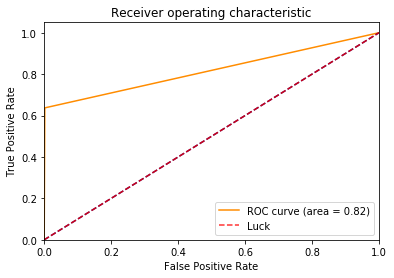

2017-08-02 07:00:00 	refes: 86400 	subjects: 3600 	auc: 0.81763117284
auc_score =  0.845659722222 	feature importances: [ 0.1   0.1   0.08  0.64  0.06  0.02]


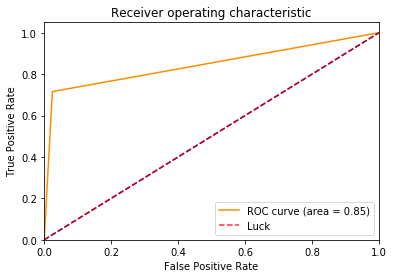

2017-08-02 08:00:00 	refes: 86400 	subjects: 3600 	auc: 0.845659722222
auc_score =  0.563792438272 	feature importances: [ 0.14  0.16  0.2   0.34  0.08  0.08]


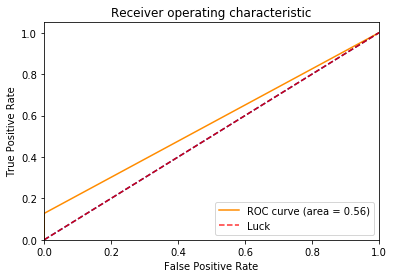

2017-08-02 09:00:00 	refes: 86400 	subjects: 3600 	auc: 0.563792438272
auc_score =  0.99537037037 	feature importances: [ 0.14  0.16  0.3   0.14  0.16  0.1 ]


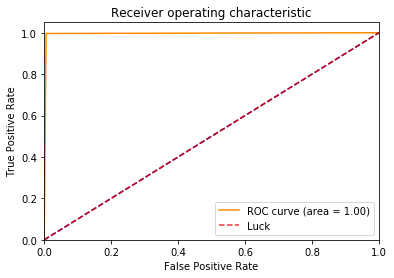

2017-08-02 10:00:00 	refes: 86400 	subjects: 3600 	auc: 0.99537037037
auc_score =  0.613136574074 	feature importances: [ 0.14  0.22  0.16  0.22  0.14  0.12]


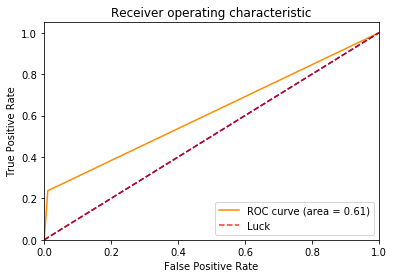

2017-08-02 11:00:00 	refes: 86400 	subjects: 3600 	auc: 0.613136574074
auc_score =  0.5 	feature importances: [ 0.1   0.08  0.2   0.32  0.1   0.2 ]
2017-08-02 12:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.499922839506 	feature importances: [ 0.22  0.16  0.14  0.3   0.08  0.1 ]
2017-08-02 13:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499922839506
auc_score =  0.499980709877 	feature importances: [ 0.18  0.06  0.14  0.34  0.12  0.16]
2017-08-02 14:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.499980709877 	feature importances: [ 0.04  0.18  0.26  0.22  0.14  0.16]
2017-08-02 15:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.5 	feature importances: [ 0.14  0.12  0.06  0.38  0.18  0.12]
2017-08-02 16:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.24  0.16  0.06  0.32  0.08  0.14]
2017-08-02 17:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 

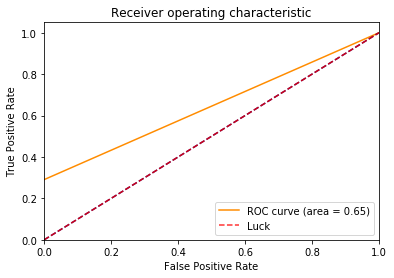

2017-08-04 20:00:00 	refes: 86400 	subjects: 3600 	auc: 0.64537037037
auc_score =  0.823051697531 	feature importances: [ 0.08  0.12  0.36  0.2   0.04  0.2 ]


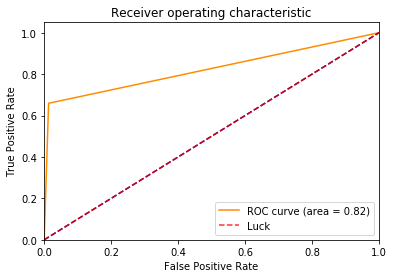

2017-08-04 21:00:00 	refes: 86400 	subjects: 3600 	auc: 0.823051697531
auc_score =  0.499961419753 	feature importances: [ 0.16  0.22  0.24  0.08  0.2   0.1 ]
2017-08-04 22:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499961419753
auc_score =  0.49994212963 	feature importances: [ 0.16  0.12  0.26  0.1   0.16  0.2 ]
2017-08-04 23:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212963
auc_score =  0.499980709877 	feature importances: [ 0.2   0.2   0.12  0.1   0.26  0.12]
2017-08-05 00:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.5 	feature importances: [ 0.12  0.18  0.18  0.24  0.12  0.16]
2017-08-05 01:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.16  0.12  0.26  0.12  0.16  0.18]
2017-08-05 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.499980709877 	feature importances: [ 0.22  0.22  0.2   0.1   0.12  0.14]
2017-08-05 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.506481

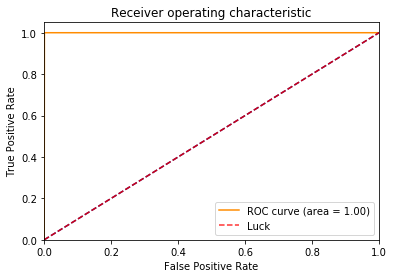

2017-08-05 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.999672067901
auc_score =  0.70825617284 	feature importances: [ 0.2   0.22  0.14  0.2   0.04  0.2 ]


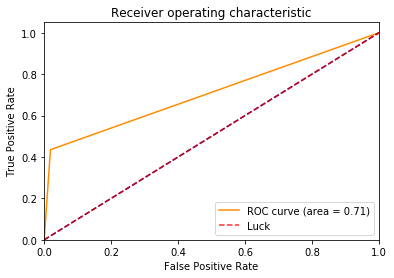

2017-08-05 06:00:00 	refes: 86400 	subjects: 3600 	auc: 0.70825617284
auc_score =  0.499980709877 	feature importances: [ 0.14  0.22  0.24  0.1   0.16  0.14]
2017-08-05 07:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.5 	feature importances: [ 0.16  0.2   0.2   0.04  0.14  0.26]
2017-08-05 08:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.49994212963 	feature importances: [ 0.16  0.14  0.24  0.14  0.26  0.06]
2017-08-05 09:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212963
auc_score =  0.5 	feature importances: [ 0.12  0.12  0.12  0.26  0.18  0.2 ]
2017-08-05 10:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.3   0.16  0.16  0.12  0.08  0.18]
2017-08-05 11:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.500405092593 	feature importances: [ 0.12  0.14  0.16  0.18  0.14  0.26]
2017-08-05 12:00:00 	refes: 86400 	subjects: 3600 	auc: 0.500405092593
auc_score =  0.5 	feature importances: [ 0.1

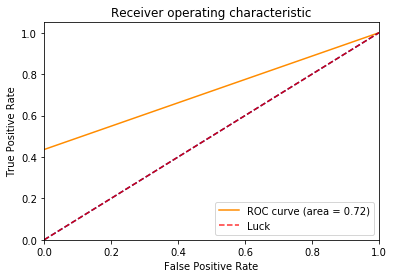

2017-08-06 15:00:00 	refes: 86400 	subjects: 3600 	auc: 0.718055555556
auc_score =  0.499980709877 	feature importances: [ 0.04  0.14  0.3   0.2   0.16  0.16]
2017-08-06 16:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.49994212963 	feature importances: [ 0.14  0.24  0.14  0.12  0.14  0.22]
2017-08-06 17:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212963
auc_score =  0.5 	feature importances: [ 0.14  0.18  0.12  0.16  0.2   0.2 ]
2017-08-06 18:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.28  0.18  0.12  0.26  0.06  0.1 ]
2017-08-06 19:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.49994212963 	feature importances: [ 0.26  0.2   0.12  0.24  0.14  0.04]
2017-08-06 20:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212963
auc_score =  0.5 	feature importances: [ 0.2   0.14  0.12  0.22  0.14  0.18]
2017-08-06 21:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.18

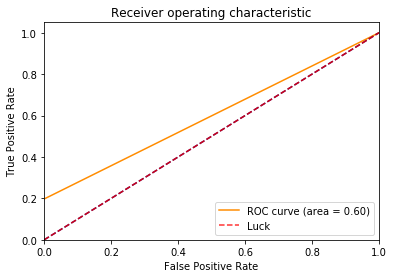

2017-08-07 01:00:00 	refes: 86400 	subjects: 3600 	auc: 0.598611111111
auc_score =  0.50368441358 	feature importances: [ 0.12  0.2   0.2   0.18  0.2   0.1 ]
2017-08-07 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.50368441358
auc_score =  0.499980709877 	feature importances: [ 0.3   0.18  0.1   0.12  0.08  0.22]
2017-08-07 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.5 	feature importances: [ 0.12  0.18  0.18  0.22  0.18  0.12]
2017-08-07 04:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.499961419753 	feature importances: [ 0.18  0.12  0.24  0.22  0.08  0.16]
2017-08-07 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499961419753
auc_score =  0.499980709877 	feature importances: [ 0.22  0.28  0.12  0.14  0.08  0.16]
2017-08-07 06:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.499980709877 	feature importances: [ 0.28  0.14  0.16  0.18  0.14  0.1 ]
2017-08-07 07:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877

In [18]:
#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    auc_score = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['auc_score']] = auc_score
    print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    #if count>2: break
    


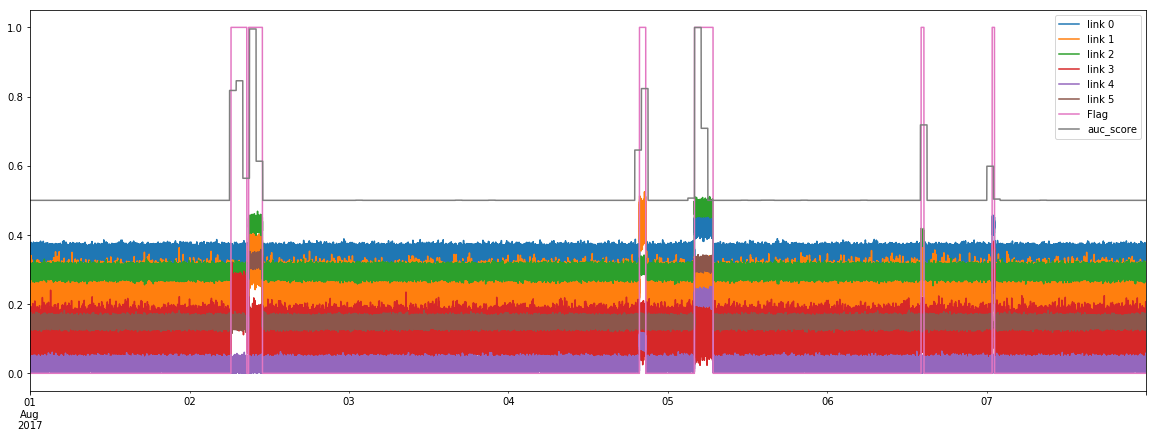

In [19]:
df.plot(figsize=(20,7))


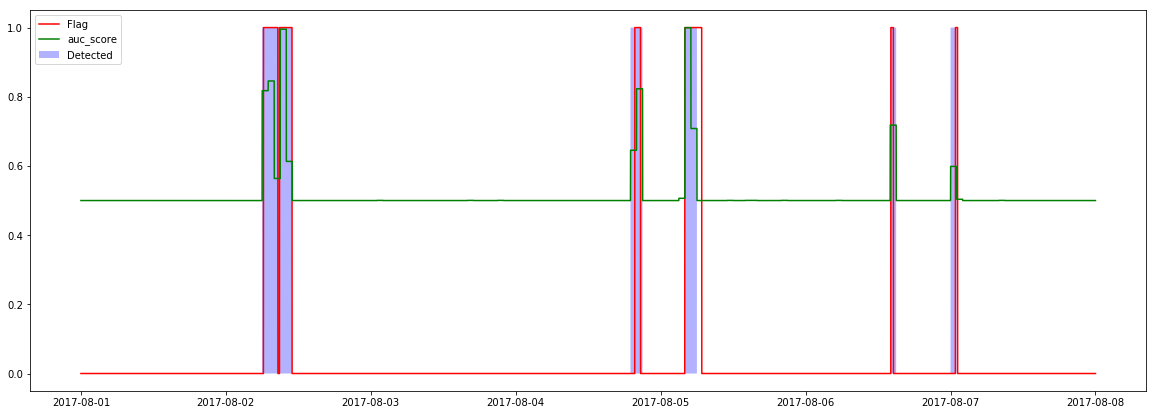

In [20]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.auc_score>0.55,'Detected']=1
df.head()
ax.plot(df.Flag, 'r')
ax.plot(df.auc_score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()